# Assignment 1 - mkecera3@gatech.edu

## Import libraries

In [2]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn import metrics
import torch.nn.functional as F
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from sklearn import preprocessing
from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import svm

/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


## Load and save the datasets

Start of citation - the following code was addapted from https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
# transform = transforms.Compose([transforms.ToTensor()])

trainset = datasets.MNIST('./data', download=False, train=True, transform=transform)
valset = datasets.MNIST('./data', download=False, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

## Neural network

### MNIST dataset

In [4]:
def nnPredict(model, valloader, criterion):
    correct_count, all_count = 0, 0
    running_loss = 0
    for images,labels in valloader:
        images = images.view(images.shape[0], -1)
        with torch.no_grad():
                output = model(images)
                loss = criterion(output, labels)
                running_loss += loss.item()
        
#         print(images.shape)
#         print(labels.shape)

        for i in range(len(labels)):
            img = images[i].view(1, 784)
#             print(img.shape)
            with torch.no_grad():
                logps = model(img)

            ps = torch.exp(logps)
            probab = list(ps.numpy()[0])
            pred_label = probab.index(max(probab))
            true_label = labels.numpy()[i]
            if(true_label == pred_label):
                correct_count += 1
            all_count += 1

#     print("Number Of Images Tested =", all_count)
#     print("Model Accuracy =", (correct_count/all_count))
#     print("Testing Loss  =", (running_loss/len(valloader)))
    
    return running_loss/len(valloader), correct_count, all_count

In [29]:
input_size = 784
hidden_sizes = [128, 64]
output_size = 10
drop_out = 0.2

model = nn.Sequential(
    nn.Linear(input_size, hidden_sizes[0]),
    nn.ReLU(),
    # nn.Dropout(drop_out, inplace=True),
    nn.Linear(hidden_sizes[0], hidden_sizes[1]),
    nn.ReLU(),
    # nn.Dropout(drop_out, inplace=True),
    nn.Linear(hidden_sizes[1], output_size),
    nn.LogSoftmax(dim=1)
    )

In [30]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

In [111]:
def trainNN(model):
    optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
    time0 = time()
    epochs = 30
    lossData = []
    accData = []
    for e in range(epochs):
        running_loss = 0
        for images, labels in trainloader:
            # Flatten MNIST images into a 784 long vector
            images = images.view(images.shape[0], -1)
        
            # Training pass
            optimizer.zero_grad()
            
            output = model(images)
            loss = criterion(output, labels)
            
            #This is where the model learns by backpropagating
            loss.backward()
            
            #And optimizes its weights here
            optimizer.step()
            
            running_loss += loss.item()
        else:
            print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
            
        testingLoss, correctCount, allCount = nnPredict(model, valloader, criterion)
        print("Testing Loss  =", (testingLoss))
        
        lossData.append([e, running_loss/len(trainloader), 'Training Error'])
        lossData.append([e, testingLoss, 'Testing Error'])
        accData.append([e, correctCount / allCount])
    
    return lossData, accData    
    print("\nTraining Time (in minutes) =",(time()-time0)/60)

In [32]:
lossDataBaseline, accDataBaseline = trainNN(model)

Epoch 0 - Training loss: 0.6388288029570823
Testing Loss  = 0.3189106638644152
Epoch 1 - Training loss: 0.28948491411422617
Testing Loss  = 0.23416888860950044
Epoch 2 - Training loss: 0.2249999368932646
Testing Loss  = 0.1868553241821611
Epoch 3 - Training loss: 0.1790516836000785
Testing Loss  = 0.16003700927089734
Epoch 4 - Training loss: 0.14891299816456113
Testing Loss  = 0.13367659304362195
Epoch 5 - Training loss: 0.12737077798670543
Testing Loss  = 0.1340204091018932
Epoch 6 - Training loss: 0.11067034249037092
Testing Loss  = 0.11591218480733549
Epoch 7 - Training loss: 0.09797333163727544
Testing Loss  = 0.11298200991716545
Epoch 8 - Training loss: 0.08845018377817516
Testing Loss  = 0.09588803105637621
Epoch 9 - Training loss: 0.07864884761865062
Testing Loss  = 0.09008015080052577
Epoch 10 - Training loss: 0.07079477846346446
Testing Loss  = 0.10170706827490097
Epoch 11 - Training loss: 0.06542237101024442
Testing Loss  = 0.089801016764917
Epoch 12 - Training loss: 0.060059

In [33]:
accDataBaseline = [[row[0], row[1], 'Baseline Accuracy'] for row in accDataBaseline]

In [35]:
lossDataBaseline = pd.DataFrame.from_records(lossDataBaseline, columns=["Epoch", "Loss", "Stage"])
accDataBaseline = pd.DataFrame.from_records(accDataBaseline, columns=["Epoch", "Accuracy", "Stage"])

Text(0.5, 1.0, 'Baseline NN')

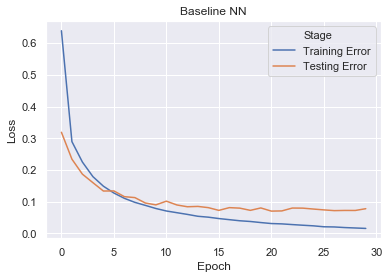

In [36]:
# vizualize train and test error across iterations
sns.set(
    style="darkgrid"
    )

sns.lineplot(
    x="Epoch", y="Loss",
    hue="Stage",
    data=lossDataBaseline
    ).set_title('Baseline NN')

Text(0.5, 1.0, '3 hidden NN')

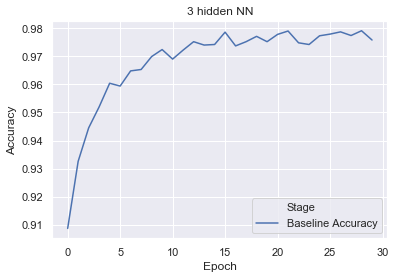

In [37]:
sns.set(
    style="darkgrid"
    )

sns.lineplot(
    x="Epoch", y="Accuracy",
    hue="Stage",
    data=accDataBaseline
    ).set_title('3 hidden NN')

In [54]:
input_size = 784
hidden_sizes = [256, 128, 64]
output_size = 10
drop_out = 0.2

model_complex = nn.Sequential(
    nn.Linear(input_size, hidden_sizes[0]),
    nn.ReLU(),
    # nn.Dropout(drop_out, inplace=True),
    nn.Linear(hidden_sizes[0], hidden_sizes[1]),
    nn.ReLU(),
    # nn.Dropout(drop_out, inplace=True),
    nn.Linear(hidden_sizes[1], hidden_sizes[2]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[2], output_size),
    nn.LogSoftmax(dim=1)
    )

In [55]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model_complex(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

In [56]:
lossDataComplex, accDataComplex = trainNN(model_complex)

Epoch 0 - Training loss: 0.8473138511022017
Testing Loss  = 0.3307117481899869
Epoch 1 - Training loss: 0.2912796917023943
Testing Loss  = 0.22506481200266795
Epoch 2 - Training loss: 0.2075264793135591
Testing Loss  = 0.16889226412887026
Epoch 3 - Training loss: 0.16017327677490298
Testing Loss  = 0.14147812810245972
Epoch 4 - Training loss: 0.12888987182276146
Testing Loss  = 0.11858063027452512
Epoch 5 - Training loss: 0.10883337905261117
Testing Loss  = 0.12177232546126766
Epoch 6 - Training loss: 0.09255026683791169
Testing Loss  = 0.10761425006470293
Epoch 7 - Training loss: 0.08244190074161871
Testing Loss  = 0.08857558788672375
Epoch 8 - Training loss: 0.07194530049007314
Testing Loss  = 0.08692883555391792
Epoch 9 - Training loss: 0.06399637720843496
Testing Loss  = 0.08422549636026097
Epoch 10 - Training loss: 0.05815240328506962
Testing Loss  = 0.09156318818913049
Epoch 11 - Training loss: 0.053317674675952394
Testing Loss  = 0.08911180915607578
Epoch 12 - Training loss: 0.0

In [57]:
accDataComplex = [[row[0], row[1], 'More nodes and layers Accuracy'] for row in accDataComplex]

In [60]:
lossDataComplex = pd.DataFrame.from_records(lossDataComplex, columns=["Epoch", "Loss", "Stage"])
accDataComplex = pd.DataFrame.from_records(accDataComplex, columns=["Epoch", "Accuracy", "Stage"])

Text(0.5, 1.0, '3 hidden NN')

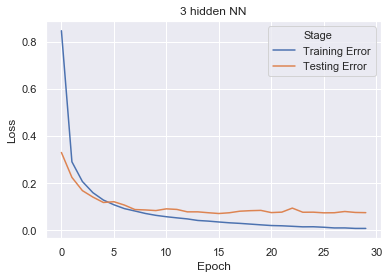

In [61]:
# vizualize train and test error across iterations
sns.set(
    style="darkgrid"
    )

sns.lineplot(
    x="Epoch", y="Loss",
    hue="Stage",
    data=lossDataComplex
    ).set_title('3 hidden NN')

Text(0.5, 1.0, '3 hidden NN')

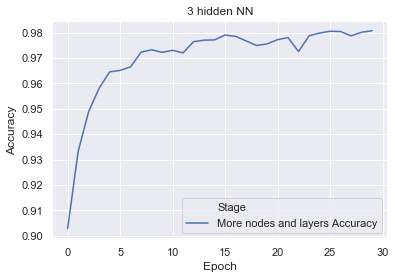

In [62]:
sns.set(
    style="darkgrid"
    )

sns.lineplot(
    x="Epoch", y="Accuracy",
    hue="Stage",
    data=accDataComplex
    ).set_title('3 hidden NN')

End of citation - the preceding code was addapted from https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627





In [127]:
input_size = 784
hidden_sizes = [256, 128, 64]
output_size = 10
drop_out = 0.2

model_dropout = nn.Sequential(
    nn.Linear(input_size, hidden_sizes[0]),
    nn.ReLU(),
    nn.Dropout(drop_out, inplace=True),
    nn.Linear(hidden_sizes[0], hidden_sizes[1]),
    nn.ReLU(),
    # nn.Dropout(drop_out, inplace=True),
    nn.Linear(hidden_sizes[1], hidden_sizes[2]),
    nn.ReLU(),
    # nn.Dropout(drop_out, inplace=True),
    nn.Linear(hidden_sizes[2], output_size),
    nn.LogSoftmax(dim=1)
    )

In [128]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model_dropout(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

In [129]:
lossDataDropout, accDataDropout = trainNN(model_dropout)

KeyboardInterrupt: 

In [0]:
accDataDropout = [[row[0], row[1], 'Dropout Accuracy'] for row in accDataDropout]

In [0]:
lossDataDropout = pd.DataFrame.from_records(lossDataDropout, columns=["Epoch", "Loss", "Stage"])
accDataDropout = pd.DataFrame.from_records(accDataDropout, columns=["Epoch", "Accuracy", "Stage"])

In [0]:
# vizualize train and test error across iterations
sns.set(
    style="darkgrid"
    )

sns.lineplot(
    x="Epoch", y="Loss",
    hue="Stage",
    data=lossDataDropout
    ).set_title('Dropout NN')

Text(0.5, 1.0, 'Dropout NN')

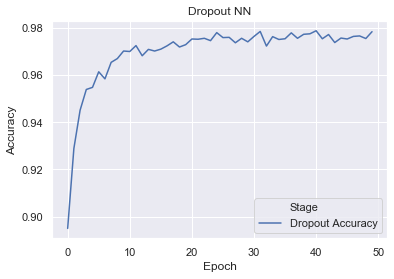

In [118]:
sns.set(
    style="darkgrid"
    )

sns.lineplot(
    x="Epoch", y="Accuracy",
    hue="Stage",
    data=accDataDropout
    ).set_title('Dropout NN')

In [119]:
accData = accDataBaseline.copy()
accData = accData.append(accDataComplex)
accData = accData.append(accDataDropout)

Text(0.5, 1.0, 'Accuracy of NN versions')

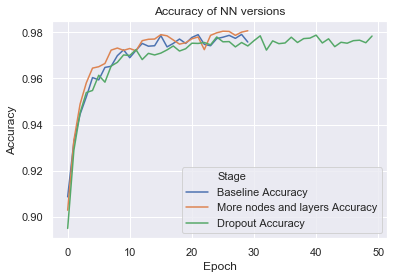

In [120]:
sns.set(
    style="darkgrid"
    )

sns.lineplot(
    x="Epoch", y="Accuracy",
    hue="Stage",
    data=accData
    ).set_title('Accuracy of NN versions')

### Credit default dataset

In [133]:
# load dataset
creditDataDf = pd.read_excel('./data/default of credit card clients.xls', header=1)
creditDataDf = creditDataDf.drop(columns=['ID'])

In [134]:
# create dummy variables from categorical
creditDataDf = pd.get_dummies(creditDataDf, prefix=['SEX', 'EDUCATION', 'MARRIAGE'], columns=['SEX', 'EDUCATION', 'MARRIAGE'])

In [135]:
# drop last mummy variable
creditDataDf = creditDataDf.drop(columns=['SEX_2', 'EDUCATION_6', 'MARRIAGE_3'])

In [136]:
y = creditDataDf['default payment next month']
creditDataDf = creditDataDf.drop(columns=['default payment next month'])

In [137]:
# normalize the data
x = creditDataDf.values #returns a numpy array
min_max_scaler = preprocessing.StandardScaler()
x_scaled = min_max_scaler.fit_transform(x)
creditDataDf = pd.DataFrame(x_scaled, columns=creditDataDf.columns)

In [183]:
creditDataDf

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,SEX_1,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2
0,-1.136720,-1.246020,1.794564,1.782348,-0.696663,-0.666599,-1.530046,-1.486041,-0.642501,-0.647399,...,-0.810161,-0.021608,-0.738375,1.066900,-0.442752,-0.064163,-0.097063,-0.042465,1.093780,-1.066471
1,-0.365981,-1.029047,-0.874991,1.782348,0.138865,0.188746,0.234917,1.992316,-0.659219,-0.666747,...,-0.810161,-0.021608,-0.738375,1.066900,-0.442752,-0.064163,-0.097063,-0.042465,-0.914261,0.937672
2,-0.597202,-0.161156,0.014861,0.111736,0.138865,0.188746,0.234917,0.253137,-0.298560,-0.493899,...,-0.810161,-0.021608,-0.738375,1.066900,-0.442752,-0.064163,-0.097063,-0.042465,-0.914261,0.937672
3,-0.905498,0.164303,0.014861,0.111736,0.138865,0.188746,0.234917,0.253137,-0.057491,-0.013293,...,-0.810161,-0.021608,-0.738375,1.066900,-0.442752,-0.064163,-0.097063,-0.042465,1.093780,-1.066471
4,-0.905498,2.334029,-0.874991,0.111736,-0.696663,0.188746,0.234917,0.253137,-0.578618,-0.611318,...,1.234323,-0.021608,-0.738375,1.066900,-0.442752,-0.064163,-0.097063,-0.042465,1.093780,-1.066471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0.404759,0.381275,0.014861,0.111736,0.138865,0.188746,0.234917,0.253137,1.870379,2.018136,...,1.234323,-0.021608,-0.738375,-0.937295,2.258602,-0.064163,-0.097063,-0.042465,1.093780,-1.066471
29996,-0.134759,0.815221,-0.874991,-0.723570,-0.696663,-0.666599,0.234917,0.253137,-0.672786,-0.665299,...,1.234323,-0.021608,-0.738375,-0.937295,2.258602,-0.064163,-0.097063,-0.042465,-0.914261,0.937672
29997,-1.059646,0.164303,3.574267,2.617654,1.809921,-0.666599,0.234917,0.253137,-0.647227,-0.643830,...,1.234323,-0.021608,-0.738375,1.066900,-0.442752,-0.064163,-0.097063,-0.042465,-0.914261,0.937672
29998,-0.674276,0.598248,0.904712,-0.723570,0.138865,0.188746,0.234917,-0.616452,-0.717982,0.410269,...,1.234323,-0.021608,-0.738375,-0.937295,2.258602,-0.064163,-0.097063,-0.042465,1.093780,-1.066471


In [139]:
X_train, X_test, y_train, y_test = train_test_split(creditDataDf, y, test_size=0.2, random_state=37)

In [140]:
print(X_train.columns)
print(len(X_train.columns))

Index(['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
       'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'SEX_1', 'EDUCATION_0',
       'EDUCATION_1', 'EDUCATION_2', 'EDUCATION_3', 'EDUCATION_4',
       'EDUCATION_5', 'MARRIAGE_0', 'MARRIAGE_1', 'MARRIAGE_2'],
      dtype='object')
30


In [141]:
sum(y_train)/len(y_train)

0.22145833333333334

In [142]:
# convert data to tensors
X_train_tensor = torch.tensor(X_train.values.astype(np.float32))
X_test_tensor = torch.tensor(X_test.values.astype(np.float32))
y_train_tensor = torch.tensor(y_train.values.astype(np.int))
y_test_tensor = torch.tensor(y_test.values.astype(np.int))

In [143]:
trainTorchDataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
valTorchDataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

In [144]:
len(valTorchDataset)

6000

In [145]:
trainloader2 = torch.utils.data.DataLoader(trainTorchDataset, batch_size=64, shuffle=True)
valloader2 = torch.utils.data.DataLoader(valTorchDataset, batch_size=len(valTorchDataset), shuffle=True)

In [157]:
def nnPredictTabular(model2, valloader2, criterion):
    correct_count, all_count = 0, 0
    running_loss = 0
    probList = []
    for rows,labels in valloader2:
        
#         print(rows.shape)
#         print(labels.shape)
        
        with torch.no_grad():
                output = model2(rows)
                loss = criterion(output, labels)
                running_loss += loss.item()


        for i in range(len(labels)):
            row = rows[i].view(1, 30)
#             print(row.shape)
            with torch.no_grad():
                logps = model2(row)

            ps = torch.exp(logps)
            probab = list(ps.numpy()[0])
            probList.append(probab)
            pred_label = probab.index(max(probab))
            true_label = labels.numpy()[i]
            if(true_label == pred_label):
                correct_count += 1
            all_count += 1

#     print("Number Of Images Tested =", all_count)
#     print("Model Accuracy =", (correct_count/all_count))
#     print("Testing Loss  =", (running_loss/len(valloader2)))
    
    return running_loss/len(valloader2), correct_count, all_count, probList

In [184]:
input_size = 30
hidden_sizes = [25, 15]
output_size = 2

modelTabBaseline = nn.Sequential(
    nn.Linear(input_size, hidden_sizes[0]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[0], hidden_sizes[1]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[1], output_size),
    nn.LogSoftmax(dim=1)
    )
criterion = nn.NLLLoss()

In [185]:
def trainTabNN(model):
    # optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
    optimizer = optim.Adam(model.parameters(), lr=0.01, momentum=0.5)
    time0 = time()
    epochs = 50
    lossData = []
    accData=[]
    for e in range(epochs):
        running_loss = 0
        for rows, labels in trainloader2:
                
            # Training pass
            optimizer.zero_grad()
            
            output = model(rows)
            loss = criterion(output, labels)
            
            #This is where the model learns by backpropagating
            loss.backward()
            
            #And optimizes its weights here
            optimizer.step()
            
            running_loss += loss.item()
        else:
            print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader2)))
            
        testingLoss, correctCount, allCount, proba = nnPredictTabular(model, valloader2, criterion)
        print("Testing Loss  =", (testingLoss))
        print("Testing Accuracy  =", (correctCount / allCount))
        
        lossData.append([e, running_loss/len(trainloader2), 'Training Loss'])
        lossData.append([e, testingLoss, 'Testing Loss'])
        accData.append([e, correctCount / allCount])
    
    return lossData, accData
        
    print("\nTraining Time (in minutes) =",(time()-time0)/60)

In [170]:
lossDataBaseline, accDataBaseline = trainTabNN(modelTabBaseline)

Epoch 0 - Training loss: 0.4269692822297414
Testing Loss  = 0.4374392032623291
Testing Accuracy  = 0.8153333333333334
Epoch 1 - Training loss: 0.4268249479532242
Testing Loss  = 0.437289834022522
Testing Accuracy  = 0.8145
Epoch 2 - Training loss: 0.4266664400100708
Testing Loss  = 0.43734505772590637
Testing Accuracy  = 0.8141666666666667
Epoch 3 - Training loss: 0.4265760573546092
Testing Loss  = 0.4372442960739136
Testing Accuracy  = 0.8148333333333333
Epoch 4 - Training loss: 0.42648619922002157
Testing Loss  = 0.43713274598121643
Testing Accuracy  = 0.815
Epoch 5 - Training loss: 0.4263653464714686
Testing Loss  = 0.43722838163375854
Testing Accuracy  = 0.8148333333333333
Epoch 6 - Training loss: 0.4262324495712916
Testing Loss  = 0.4368748366832733
Testing Accuracy  = 0.8153333333333334
Epoch 7 - Training loss: 0.42617001136144
Testing Loss  = 0.43713387846946716
Testing Accuracy  = 0.8151666666666667
Epoch 8 - Training loss: 0.4260752577384313
Testing Loss  = 0.4367043375968933


In [171]:
testingLoss, correctCount, allCount, proba = nnPredictTabular(modelTabBaseline, valloader2, criterion)

In [172]:
proba = [row[1] for row in proba]

In [173]:
roc_auc_score(y_test, proba)

0.5119317245107111

In [174]:
accDataBaseline = [[row[0], row[1], 'Baseline Accuracy'] for row in accDataBaseline]
lossDataBaseline = pd.DataFrame.from_records(lossDataBaseline, columns=["Epoch", "Loss", "Stage"])
accDataBaseline = pd.DataFrame.from_records(accDataBaseline, columns=["Epoch", "Accuracy", "Stage"])

Text(0.5, 1.0, 'Baseline NN')

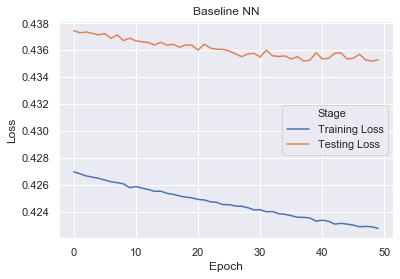

In [175]:
sns.set(
    style="darkgrid"
    )

sns.lineplot(
    x="Epoch", y="Loss",
    hue="Stage",
    data=lossDataBaseline
    ).set_title('Baseline NN')

Text(0.5, 1.0, 'Baseline NN')

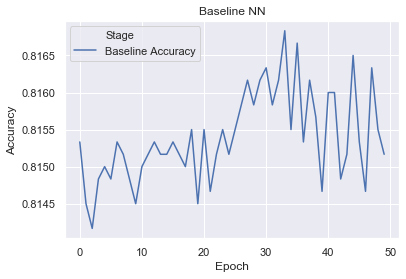

In [176]:
sns.set(
    style="darkgrid"
    )
    
sns.lineplot(
    x="Epoch", y="Accuracy",
    hue="Stage",
    data=accDataBaseline
    ).set_title('Baseline NN')

In [186]:
input_size = 30
hidden_sizes = [25, 20, 20, 20, 15, 15]
output_size = 2

modelTabLarge = nn.Sequential(
    nn.Linear(input_size, hidden_sizes[0]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[0], hidden_sizes[1]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[1], hidden_sizes[2]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[2], hidden_sizes[3]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[3], hidden_sizes[4]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[4], hidden_sizes[5]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[5], output_size),
    nn.LogSoftmax(dim=1)
    )
criterion = nn.NLLLoss()

In [187]:
lossDataLarge, accDataLarge = trainTabNN(modelTabLarge)

Epoch 0 - Training loss: 0.5545847500960032
Testing Loss  = 0.5277403593063354
Testing Accuracy  = 0.7798333333333334
Epoch 1 - Training loss: 0.5290430279572805
Testing Loss  = 0.5272635817527771
Testing Accuracy  = 0.7798333333333334
Epoch 2 - Training loss: 0.5288243891398112
Testing Loss  = 0.5271463990211487
Testing Accuracy  = 0.7798333333333334
Epoch 3 - Training loss: 0.5287445731957754
Testing Loss  = 0.5270554423332214
Testing Accuracy  = 0.7798333333333334
Epoch 4 - Training loss: 0.5286488250891368
Testing Loss  = 0.5269392728805542
Testing Accuracy  = 0.7798333333333334
Epoch 5 - Training loss: 0.5285130455493927
Testing Loss  = 0.5268210768699646
Testing Accuracy  = 0.7798333333333334
Epoch 6 - Training loss: 0.5283481462796529
Testing Loss  = 0.5266651511192322
Testing Accuracy  = 0.7798333333333334
Epoch 7 - Training loss: 0.5281311544577281
Testing Loss  = 0.5263593792915344
Testing Accuracy  = 0.7798333333333334
Epoch 8 - Training loss: 0.5276988891760508
Testing Loss

In [188]:
accDataLarge = [[row[0], row[1], '5 hidden Accuracy'] for row in accDataLarge]
lossDataLarge = pd.DataFrame.from_records(lossDataLarge, columns=["Epoch", "Loss", "Stage"])
accDataLarge = pd.DataFrame.from_records(accDataLarge, columns=["Epoch", "Accuracy", "Stage"])

Text(0.5, 1.0, 'Baseline NN')

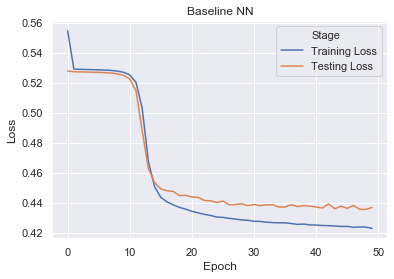

In [189]:
sns.set(
    style="darkgrid"
    )

sns.lineplot(
    x="Epoch", y="Loss",
    hue="Stage",
    data=lossDataLarge
    ).set_title('Baseline NN')

Text(0.5, 1.0, 'Baseline NN')

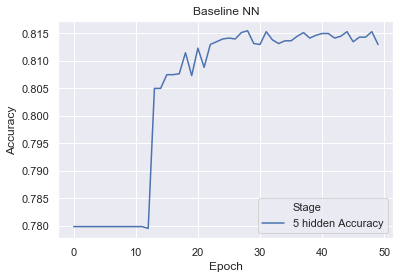

In [190]:
sns.set(
    style="darkgrid"
    )
    
sns.lineplot(
    x="Epoch", y="Accuracy",
    hue="Stage",
    data=accDataLarge
    ).set_title('Baseline NN')

In [191]:
testingLoss, correctCount, allCount, proba = nnPredictTabular(modelTabLarge, valloader2, criterion)
proba = [row[1] for row in proba]
roc_auc_score(y_test, proba)

0.5007298220227638

## Decision tree

### MNIST dataset

In [11]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=len(trainset))
valloader = torch.utils.data.DataLoader(valset, batch_size=len(valset))

In [12]:
X_train_MNIST = trainset.data.numpy()
X_test_MNIST = valset.data.numpy()

In [13]:
y_train_MNIST = trainset.targets.numpy()
y_test_MNIST = valset.targets.numpy()

In [14]:
np.bincount(y_train_MNIST) + np.bincount(y_test_MNIST)

array([6903, 7877, 6990, 7141, 6824, 6313, 6876, 7293, 6825, 6958])

In [16]:
print(X_train_MNIST.shape)
print(y_train_MNIST.shape)

(60000, 28, 28)
(60000,)


In [17]:
X_train_MNIST_reshaped = X_train_MNIST.reshape((60000, 784))
X_test_MNIST_reshaped = X_test_MNIST.reshape((10000, 784))

In [29]:
param_grid = {'max_depth': np.arange(5, 15, 30), 'ccp_alpha': np.arange(0, 300, 100) / 100000 }
gridSearchTree = GridSearchCV(tree.DecisionTreeClassifier(), param_grid, n_jobs=-1, verbose=2)
gridSearchTree.fit(X_train_MNIST_reshaped, y_train_MNIST)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   56.5s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'ccp_alpha': array([0.   , 0.001, 0.002]),
         

In [30]:
gridSearchTree.best_params_

{'ccp_alpha': 0.0, 'max_depth': 10}

In [31]:
preds = gridSearchTree.predict(X_test_MNIST_reshaped)
print(accuracy_score(preds, y_test_MNIST))

0.8657


In [32]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train_MNIST_reshaped, y_train_MNIST)
preds = clf.predict(X_test_MNIST_reshaped)
print(accuracy_score(preds, y_test_MNIST))

0.8776


In [20]:
preds

array([7, 2, 1, ..., 4, 5, 6])

### Credit default dataset

In [192]:
np.bincount(y_train) + np.bincount(y_test)

array([23364,  6636])

In [197]:
param_grid = {'max_depth': np.arange(3, 17), 'ccp_alpha': np.arange(0, 300, 50) / 10000 }
gridSearchTree = GridSearchCV(tree.DecisionTreeClassifier(), param_grid, n_jobs=-1, verbose=2)
gridSearchTree.fit(X_train, y_train)

Fitting 5 folds for each of 84 candidates, totalling 420 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:   25.8s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'ccp_alpha': array([0.   , 0.005, 0.01 , 0.015, 0.02

In [200]:
preds = gridSearchTree.predict(X_test)
probs = gridSearchTree.predict_proba(X_test)
print(accuracy_score(preds, y_test))
probs = [row[1] for row in probs]
print(roc_auc_score(y_test, probs))
print(gridSearchTree.best_params_)

0.815
0.724442841313136
{'ccp_alpha': 0.0, 'max_depth': 3}


In [201]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
preds = clf.predict(X_test)
probs = clf.predict_proba(X_test)
print(accuracy_score(preds, y_test))

0.7243333333333334


In [195]:
probs = [row[1] for row in probs]
roc_auc_score(y_test, probs)

0.6149844223202258

In [196]:
probs

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0

## Boosting

### MNIST

In [ ]:
gb_clf = GradientBoostingClassifier(
    verbose=1,
    max_features="auto",
    n_estimators=5,
    max_depth=5
)
gb_clf.fit(X_train_MNIST_reshaped, y_train_MNIST)
preds = gb_clf.predict(X_test_MNIST_reshaped)
print(accuracy_score(preds, y_test_MNIST))

### Credit default

In [ ]:
gb_clf = GradientBoostingClassifier()
gb_clf.fit(X_train, y_train)
preds = gb_clf.predict(X_test)
probs = gb_clf.predict_proba(X_test)
print(accuracy_score(preds, y_test))

In [ ]:
probs = [row[1] for row in probs]
roc_auc_score(y_test, probs)

## KNN

### MNIST

In [ ]:
kNN = KNeighborsClassifier(
    n_neighbors=10
)
kNN.fit(X_train_MNIST_reshaped, y_train_MNIST)
preds = kNN.predict(X_test_MNIST_reshaped)
print(accuracy_score(preds, y_test_MNIST))

### Credit default

In [ ]:
kNN = KNeighborsClassifier(
    n_neighbors=5
)
kNN.fit(X_train, y_train)
preds = kNN.predict(X_test)
probs = kNN.predict_proba(X_test)
print(accuracy_score(preds, y_test))

In [ ]:
probs = kNN.predict_proba(X_test)
probs = [row[1] for row in probs]
roc_auc_score(y_test, probs)

## SVM

### MNIST

In [47]:
clf = svm.SVC()
clf.fit(X_train_MNIST_reshaped, y_train_MNIST)
preds = clf.predict(X_test_MNIST_reshaped)
print(accuracy_score(preds, y_test_MNIST))

0.9792


In [26]:
### MNIST

In [45]:
clf = svm.SVC()
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
print(accuracy_score(preds, y_test))

0.8166666666666667
